In [224]:
!pip install rdkit-pypi
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.1 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for rdkit from https://files.pythonhosted.org/packages/04/0c/bf1325c3232230d6d5bf9df985c6fd01b121da618e88ccf98a70428fe153/rdkit-2023.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 19.8 MB/s eta 0:00:0000:01:00:01


In [225]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from rdkit import Chem
import re
from collections import Counter
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [226]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('/kaggle/input/dl-bbbp/BBBP.csv')

/kaggle/input/dl-bbbp/BBBP.csv


In [227]:
SMI_REGEX_PATTERN = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#||\+|\\\\\/|:||@|\?|>|\*|\$|\%[0–9]{2}|[0–9])"

def tokenize_smiles(smiles):
    # Use regular expression to find atom symbols
    tokens = re.findall(r"[A-Za-z0-9)(=\\/@]+|@@|@", smiles)
    tokens1 = re.findall(r"[)(=\\/@]+|@@|@", smiles)
    tokens2 = re.findall(r"[A-Z][a-z]*\d*", smiles)
    tokens = tokens1 + tokens2
    tokens = re.findall(SMI_REGEX_PATTERN, smiles)
    return tokens

df['Tokenized_SMILES'] = df['smiles'].apply(tokenize_smiles)
# Calculate token frequencies
all_tokens = [token for tokens in df['Tokenized_SMILES'] for token in tokens]
token_freq = Counter(all_tokens)
uniq_tokens = list(token_freq.keys())
num_tokens = len(uniq_tokens)
# print('All tokens are = ',uniq_tokens)
print(token_freq,'\n')

print('Number of token = ', num_tokens, '\n')
# Select top N frequent tokens
N = 10
top_tokens = [token for token, freq in token_freq.most_common(N)]
print(N, 'top_tokens = ', top_tokens)
df = df[df['Tokenized_SMILES'].map(lambda d: len(d)) > 0]

Counter({'C': 26859, '': 14631, '(': 10491, ')': 10491, '=': 8034, 'c': 6937, 'O': 6142, 'N': 3724, '[C@H]': 1354, '[C@@H]': 893, 'Cl': 570, 'F': 509, 'n': 472, 'S': 405, '[C@@]': 350, '[C@]': 323, '.': 163, '[S]': 103, '[N]': 77, 's': 72, '[O-]': 64, '#': 53, '[NH]': 50, '[N+]': 49, 'o': 48, 'Br': 45, '[Cl-]': 43, '[nH]': 40, '[H+]': 40, '[Na+]': 19, '9': 16, '[N@]': 14, '[P]': 11, '[N@@]': 8, '0': 8, 'I': 6, '[Br-]': 6, '[Cl]': 5, '[H]': 4, '[N-]': 4, '[n+]': 2, '[NH+]': 2, '[Na]': 2, '[C-]': 2, '[NH2+]': 2, '[NH2]': 1, '[Ca++]': 1, '[S@]': 1, '[OH-]': 1, '[nH+]': 1, '[o+]': 1, '[NH3+]': 1, '[CH2-]': 1, '[CH-]': 1, 'B': 1, '[S+]': 1, '[O+]': 1, '[NH-]': 1}) 

Number of token =  58 

10 top_tokens =  ['C', '', '(', ')', '=', 'c', 'O', 'N', '[C@H]', '[C@@H]']


In [228]:
token_to_onehot = {token: nn.functional.one_hot(torch.tensor(idx), num_classes=len(uniq_tokens)).float() for idx, token in enumerate(uniq_tokens)}

# print((token_to_onehot['@']))
# print(df['Tokenized_SMILES'])
# Convert SMILES sequences to one-hot matrices
smiles_onehot = []
for i,seq in enumerate(df['Tokenized_SMILES']):
    seq_onehot = torch.stack([token_to_onehot[token] for token in seq], dim=0)
    smiles_onehot.append(seq_onehot)

# Pad one-hot matrices
padded_onehot = nn.utils.rnn.pad_sequence(smiles_onehot, batch_first=True, padding_value=0)
# Convert labels to PyTorch tensor
labels_org = torch.tensor(df['p_np'].values, dtype=torch.float32)
flattened_onehot = padded_onehot.reshape(padded_onehot.size(0), -1)

## Creating Dataset

In [229]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(flattened_onehot, labels_org, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Create a PyTorch Dataset
class MolecularDataset(Dataset):
    def __init__(self, sequences, labels_ds):
        self.sequences = sequences
        self.labels = labels_ds

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    
full_dataset = MolecularDataset(flattened_onehot, labels_org)

train_dataset = MolecularDataset(X_train, y_train)
valid_dataset = MolecularDataset(X_valid, y_valid)
test_dataset = MolecularDataset(X_test, y_test)


## Fc Model

In [230]:

# Define the Fully Connected (FC) model
class FCModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Instantiate the model, loss function, and optimizer
input_size = flattened_onehot.size(1)
hidden_size = 64

fc_model = FCModel(input_size, hidden_size)
criterion_fc = nn.BCELoss()
optimizer_fc = optim.Adam(fc_model.parameters(), lr=0.001)


In [231]:
# Training loop for the FC model
num_epochs = 10
batch_size = 64
best_accuracy = 0.0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    fc_model.train()
    for inputs, labels in train_loader:
        optimizer_fc.zero_grad()
        outputs_fc = fc_model(inputs)
        loss_fc = criterion_fc(outputs_fc.squeeze(), labels)
        loss_fc.backward()
        optimizer_fc.step()

    # Validation
    fc_model.eval()
    with torch.no_grad():
        correct_fc = 0
        total_fc = 0
        for inputs, labels in valid_loader:
            outputs_fc = fc_model(inputs)
            predicted_fc = (outputs_fc.squeeze() > 0.5).float()
            total_fc += labels.size(0)
            correct_fc += (predicted_fc == labels).sum().item()

        accuracy_fc = correct_fc / total_fc
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy FC: {accuracy_fc * 100:.2f}%')

        # Save the best model
        if accuracy_fc > best_accuracy:
            best_accuracy = accuracy_fc
            torch.save(fc_model.state_dict(), 'best_model.pth')

# Load the best model
best_fc_model = FCModel(input_size, hidden_size)
best_fc_model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the best model on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_fc_model.eval()
with torch.no_grad():
    correct_fc = 0
    total_fc = 0
    for inputs, labels in test_loader:
        outputs_fc = best_fc_model(inputs)
        predicted_fc = (outputs_fc.squeeze() > 0.5).float()
        total_fc += labels.size(0)
        correct_fc += (predicted_fc == labels).sum().item()

    accuracy_fc = correct_fc / total_fc
    print(f'Best FC Model Test Accuracy: {accuracy_fc * 100:.2f}%')

Epoch 1/10, Validation Accuracy FC: 78.18%
Epoch 2/10, Validation Accuracy FC: 83.39%
Epoch 3/10, Validation Accuracy FC: 84.04%
Epoch 4/10, Validation Accuracy FC: 86.64%
Epoch 5/10, Validation Accuracy FC: 86.97%
Epoch 6/10, Validation Accuracy FC: 86.97%
Epoch 7/10, Validation Accuracy FC: 87.30%
Epoch 8/10, Validation Accuracy FC: 86.64%
Epoch 9/10, Validation Accuracy FC: 86.32%
Epoch 10/10, Validation Accuracy FC: 86.97%
Best FC Model Test Accuracy: 86.69%


## LSTM Model

In [232]:
class LSTMWithFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, fc_hidden_size):
        super(LSTMWithFCModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        x = self.relu(x)
        output = self.fc2(x)
        return output

input_size = flattened_onehot.size(1)
hidden_size = 64
lstm_layers = 2
fc_hidden_size = 64
lstm_model = LSTMWithFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size)
criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.01)

In [233]:
# Training loop for the FC model
num_epochs = 10
batch_size = 64
best_accuracy = 0.0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    lstm_model.train()
    for inputs, labels in train_loader:
        optimizer_lstm.zero_grad()
        outputs_lstm = lstm_model(inputs)
        loss_lstm = criterion_lstm(outputs_lstm.squeeze(), labels)
        loss_lstm.backward()
        optimizer_lstm.step()

    # Validation
    lstm_model.eval()
    with torch.no_grad():
        correct_lstm = 0
        total_lstm = 0
        for inputs, labels in valid_loader:
            outputs_lstm = lstm_model(inputs)
            predicted_lstm = (outputs_lstm.squeeze() > 0.5).float()
            total_lstm += labels.size(0)
            correct_lstm += (predicted_lstm == labels).sum().item()

        accuracy_lstm = correct_lstm / total_lstm
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy LSTM: {accuracy_lstm * 100:.2f}%')

        # Save the best model
        if accuracy_lstm > best_accuracy:
            best_accuracy = accuracy_lstm
            torch.save(lstm_model.state_dict(), 'best_model_lstm.pth')

# Load the best model
best_lstm_model = LSTMWithFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size)
best_lstm_model.load_state_dict(torch.load('best_model_lstm.pth'))

# Evaluate the best model on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_lstm_model.eval()
with torch.no_grad():
    correct_lstm = 0
    total_lstm = 0
    for inputs, labels in test_loader:
        outputs_lstm = best_lstm_model(inputs)
        predicted_lstm = (outputs_lstm.squeeze() > 0.5).float()
        total_lstm += labels.size(0)
        correct_lstm += (predicted_lstm == labels).sum().item()

    accuracy_lstm = correct_lstm / total_lstm
    print(f'Best LSTM Model Test Accuracy: {accuracy_lstm * 100:.2f}%')

Epoch 1/10, Validation Accuracy LSTM: 81.43%
Epoch 2/10, Validation Accuracy LSTM: 81.76%
Epoch 3/10, Validation Accuracy LSTM: 86.97%
Epoch 4/10, Validation Accuracy LSTM: 86.64%
Epoch 5/10, Validation Accuracy LSTM: 86.32%
Epoch 6/10, Validation Accuracy LSTM: 88.27%
Epoch 7/10, Validation Accuracy LSTM: 86.64%
Epoch 8/10, Validation Accuracy LSTM: 87.95%
Epoch 9/10, Validation Accuracy LSTM: 87.62%
Epoch 10/10, Validation Accuracy LSTM: 87.95%
Best LSTM Model Test Accuracy: 85.71%


## BiLSTM Model

In [234]:
class BiLSTMWithFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, fc_hidden_size):
        super(BiLSTMWithFCModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden_size, fc_hidden_size)  # Multiply by 2 for bidirectional
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)

    def forward(self, x):
        x, _ = self.bilstm(x)
#         x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        output = self.fc2(x)
        return output

input_size = flattened_onehot.size(1)
hidden_size = 64
lstm_layers = 2
fc_hidden_size = 32
bilstm_model = BiLSTMWithFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

In [235]:
# Training loop for the FC model
num_epochs = 10
batch_size = 64
best_accuracy = 0.0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    bilstm_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs_lstm = bilstm_model(inputs)
        loss_lstm = criterion(outputs_lstm.squeeze(), labels)
        loss_lstm.backward()
        optimizer.step()

    # Validation
    bilstm_model.eval()
    with torch.no_grad():
        correct_lstm = 0
        total_lstm = 0
        for inputs, labels in valid_loader:
            outputs_lstm = bilstm_model(inputs)
            predicted_lstm = (outputs_lstm.squeeze() > 0.5).float()
            total_lstm += labels.size(0)
            correct_lstm += (predicted_lstm == labels).sum().item()

        accuracy_lstm = correct_lstm / total_lstm
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy BiLSTM: {accuracy_lstm * 100:.2f}%')

        # Save the best model
        if accuracy_lstm > best_accuracy:
            best_accuracy = accuracy_lstm
            torch.save(bilstm_model.state_dict(), 'best_model_bilstm.pth')

# Load the best model
best_bilstm_model = BiLSTMWithFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size)
best_bilstm_model.load_state_dict(torch.load('best_model_bilstm.pth'))

# Evaluate the best model on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_bilstm_model.eval()
with torch.no_grad():
    correct_lstm = 0
    total_lstm = 0
    for inputs, labels in test_loader:
        outputs_lstm = best_bilstm_model(inputs)
        predicted_lstm = (outputs_lstm.squeeze() > 0.5).float()
        total_lstm += labels.size(0)
        correct_lstm += (predicted_lstm == labels).sum().item()

    accuracy_lstm = correct_lstm / total_lstm
    print(f'Best BiLSTM Model Test Accuracy: {accuracy_lstm * 100:.2f}%')

Epoch 1/10, Validation Accuracy BiLSTM: 77.85%
Epoch 2/10, Validation Accuracy BiLSTM: 77.85%
Epoch 3/10, Validation Accuracy BiLSTM: 80.78%
Epoch 4/10, Validation Accuracy BiLSTM: 81.11%
Epoch 5/10, Validation Accuracy BiLSTM: 84.36%
Epoch 6/10, Validation Accuracy BiLSTM: 84.36%
Epoch 7/10, Validation Accuracy BiLSTM: 88.27%
Epoch 8/10, Validation Accuracy BiLSTM: 86.97%
Epoch 9/10, Validation Accuracy BiLSTM: 86.32%
Epoch 10/10, Validation Accuracy BiLSTM: 87.30%
Best BiLSTM Model Test Accuracy: 87.66%


## KFold FC Model

In [236]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
#     print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [132]:
from torch.utils.data import DataLoader, ConcatDataset, Subset



kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
for fold, (train_index, valid_index) in enumerate(kf.split(full_dataset)):
    print(f'Fold {fold + 1}')
#     
# Create Subset for training and validation
    train_subset = Subset(full_dataset, train_index)
    valid_subset = Subset(full_dataset, valid_index)

    num_epochs_fc = 10
    batch_size_fc = 64
    

    trainloader = DataLoader(
                      train_subset, 
                      batch_size=batch_size_fc, shuffle=True)
    testloader = DataLoader(
                      valid_subset,
                      batch_size=batch_size_fc, shuffle=False)
    
    fc_model = FCModel(input_size, hidden_size)
    fc_model.apply(reset_weights)
    
    criterion_fc = nn.BCELoss()
    optimizer_fc = optim.Adam(fc_model.parameters(), lr=0.001)

    
    for epoch in range(num_epochs_fc):
        fc_model.train()

        for inputs, labels in trainloader:
            optimizer_fc.zero_grad()
            outputs_fc = fc_model(inputs)
            loss_fc = criterion_fc(outputs_fc.squeeze(), labels)
            loss_fc.backward()
            optimizer_fc.step()

    # Validation
    fc_model.eval()
    with torch.no_grad():
        correct_fc = 0
        total_fc = 0
        for inputs, labels in testloader:
            outputs_fc = fc_model(inputs)
            predicted_fc = (outputs_fc.squeeze() > 0.5).float()
            total_fc += labels.size(0)
            correct_fc += (predicted_fc == labels).sum().item()

        accuracy_fc = correct_fc / total_fc
        print(f'Validation Accuracy MLP: {accuracy_fc * 100:.2f}%')

#             # Save the best model
#             if accuracy_fc > best_accuracy:
#                 best_accuracy = accuracy_fc
#                 torch.save(fc_model.state_dict(), f'best_model_fold{fold}.pth')

    fold_accuracies.append(accuracy_fc)

# Report the average accuracy over all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f'Average Cross-Validation Accuracy: {average_accuracy * 100:.2f}%')

Fold 1
Validation Accuracy MLP: 86.59%
Fold 2
Validation Accuracy MLP: 87.56%
Fold 3
Validation Accuracy MLP: 85.12%
Fold 4
Validation Accuracy MLP: 88.29%
Fold 5
Validation Accuracy MLP: 89.02%
Average Cross-Validation Accuracy: 87.32%


## KFold LSTM Model

In [133]:
from torch.utils.data import DataLoader, ConcatDataset, Subset



kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
for fold, (train_index, valid_index) in enumerate(kf.split(full_dataset)):
    print(f'Fold {fold + 1}')
#     
# Create Subset for training and validation
    train_subset = Subset(full_dataset, train_index)
    valid_subset = Subset(full_dataset, valid_index)

    num_epochs_fc = 10
    batch_size_fc = 64
    

    trainloader = DataLoader(
                      train_subset, 
                      batch_size=batch_size_fc, shuffle=True)
    testloader = DataLoader(
                      valid_subset,
                      batch_size=batch_size_fc, shuffle=False)
    
    fc_model = LSTMWithFCModel(input_size, hidden_size, lstm_layers , fc_hidden_size)
    fc_model.apply(reset_weights)
    
    criterion_fc = nn.BCEWithLogitsLoss()
    optimizer_fc = optim.Adam(fc_model.parameters(), lr=0.001)

    
    for epoch in range(num_epochs_fc):
        fc_model.train()

        for inputs, labels in trainloader:
            optimizer_fc.zero_grad()
            outputs_fc = fc_model(inputs)
            loss_fc = criterion_fc(outputs_fc.squeeze(), labels)
            loss_fc.backward()
            optimizer_fc.step()

    # Validation
    fc_model.eval()
    with torch.no_grad():
        correct_fc = 0
        total_fc = 0
        for inputs, labels in testloader:
            outputs_fc = fc_model(inputs)
            predicted_fc = (outputs_fc.squeeze() > 0.5).float()
            total_fc += labels.size(0)
            correct_fc += (predicted_fc == labels).sum().item()

        accuracy_fc = correct_fc / total_fc
        print(f'Validation Accuracy LSTM: {accuracy_fc * 100:.2f}%')

#             # Save the best model
#             if accuracy_fc > best_accuracy:
#                 best_accuracy = accuracy_fc
#                 torch.save(fc_model.state_dict(), f'best_model_fold{fold}.pth')

    fold_accuracies.append(accuracy_fc)

# Report the average accuracy over all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f'Average Cross-Validation Accuracy: {average_accuracy * 100:.2f}%')

Fold 1
Validation Accuracy LSTM: 86.10%
Fold 2
Validation Accuracy LSTM: 85.85%
Fold 3
Validation Accuracy LSTM: 84.88%
Fold 4
Validation Accuracy LSTM: 87.80%
Fold 5
Validation Accuracy LSTM: 87.07%
Average Cross-Validation Accuracy: 86.34%


## KFold BiLSTM Model

In [134]:
from torch.utils.data import DataLoader, ConcatDataset, Subset



kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
for fold, (train_index, valid_index) in enumerate(kf.split(full_dataset)):
    print(f'Fold {fold + 1}')
#     
# Create Subset for training and validation
    train_subset = Subset(full_dataset, train_index)
    valid_subset = Subset(full_dataset, valid_index)

    num_epochs_fc = 10
    batch_size_fc = 64
    

    trainloader = DataLoader(
                      train_subset, 
                      batch_size=batch_size_fc, shuffle=True)
    testloader = DataLoader(
                      valid_subset,
                      batch_size=batch_size_fc, shuffle=False)
    
    fc_model = BiLSTMWithFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size)
    fc_model.apply(reset_weights)
    
    criterion_fc = nn.BCEWithLogitsLoss()
    optimizer_fc = optim.Adam(fc_model.parameters(), lr=0.01)

    
    for epoch in range(num_epochs_fc):
        fc_model.train()

        for inputs, labels in trainloader:
            optimizer_fc.zero_grad()
            outputs_fc = fc_model(inputs)
            loss_fc = criterion_fc(outputs_fc.squeeze(), labels)
            loss_fc.backward()
            optimizer_fc.step()

    # Validation
    fc_model.eval()
    with torch.no_grad():
        correct_fc = 0
        total_fc = 0
        for inputs, labels in testloader:
            outputs_fc = fc_model(inputs)
            predicted_fc = (outputs_fc.squeeze() > 0.5).float()
            total_fc += labels.size(0)
            correct_fc += (predicted_fc == labels).sum().item()

        accuracy_fc = correct_fc / total_fc
        print(f'Validation Accuracy BiLSTM: {accuracy_fc * 100:.2f}%')

#             # Save the best model
#             if accuracy_fc > best_accuracy:
#                 best_accuracy = accuracy_fc
#                 torch.save(fc_model.state_dict(), f'best_model_fold{fold}.pth')

    fold_accuracies.append(accuracy_fc)

# Report the average accuracy over all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f'Average Cross-Validation Accuracy: {average_accuracy * 100:.2f}%')

Fold 1
Validation Accuracy BiLSTM: 85.85%
Fold 2
Validation Accuracy BiLSTM: 86.83%
Fold 3
Validation Accuracy BiLSTM: 86.10%
Fold 4
Validation Accuracy BiLSTM: 85.85%
Fold 5
Validation Accuracy BiLSTM: 88.05%
Average Cross-Validation Accuracy: 86.54%


In [250]:
print(len((df['Tokenized_SMILES'])))
print(len(max(smiles_onehot, key=len)))
# Calculate bin edges based on the range of sequence lengths
min_length = 0
max_length = 150
num_bins = 10

bin_edges = np.linspace(min_length, max_length, num_bins + 1, endpoint=True)

# bin_edges = [20, 40, 60, 80, 100, 120, 140 ,160, 180, 200]

df['Bin'] = np.digitize(df['Tokenized_SMILES'].apply(len), bin_edges, right=True)
df['Bin'].fillna(0, inplace=True)


2050
257


In [251]:
print(len(flattened_onehot))
print(len(bin_mask))
print(len(labels_org[bin_mask]))
print(Counter(df['Bin']))

2050
2050
13
Counter({3: 737, 4: 572, 2: 335, 5: 227, 1: 71, 6: 52, 8: 20, 7: 20, 11: 9, 9: 4, 10: 3})


In [264]:
accuracy_scores = []

# Train and evaluate the model on each bin
for bin_idx in range(1,len(bin_edges)):
    bin_mask = df['Bin'] == bin_idx
    bin_dataset = MolecularDataset(flattened_onehot[bin_mask], labels_org[bin_mask])

    # Split the bin dataset into training, validation, and testing sets
    X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(bin_dataset.sequences, bin_dataset.labels, test_size=0.3, random_state=42)
    batch_size = 64
    train_loader_bin = DataLoader(MolecularDataset(X_train_bin, y_train_bin), batch_size=batch_size, shuffle=True)
    valid_loader_bin = DataLoader(MolecularDataset(X_temp_bin, y_temp_bin), batch_size=batch_size, shuffle=False)
#     test_loader_bin = DataLoader(MolecularDataset(X_test_bin, y_test_bin), batch_size=batch_size, shuffle=False)

    # Instantiate the model, loss function, and optimizer
    input_size_bin = flattened_onehot.size(1)
    hidden_size_bin = 64

    fc_model_bin = FCModel(input_size_bin, hidden_size_bin)
    fc_model_bin.apply(reset_weights)
    criterion_fc_bin = nn.BCELoss()
    optimizer_fc_bin = optim.Adam(fc_model_bin.parameters(), lr=0.001)

    # Training loop for the FC model on the current bin
    num_epochs_bin = 10
    best_accuracy_bin = 0.0

    for epoch in range(num_epochs_bin):
        fc_model_bin.train()
        for inputs, labels in train_loader_bin:
            optimizer_fc_bin.zero_grad()
            outputs_fc_bin = fc_model_bin(inputs)
            loss_fc_bin = criterion_fc_bin(outputs_fc_bin.squeeze(), labels)
            loss_fc_bin.backward()
            optimizer_fc_bin.step()

    # Validation
    fc_model_bin.eval()
    with torch.no_grad():
        correct_fc_bin = 0
        total_fc_bin = 0
        for inputs, labels in valid_loader_bin:
            outputs_fc_bin = fc_model_bin(inputs)
            predicted_fc_bin = (outputs_fc_bin.squeeze() > 0.5).float()
            total_fc_bin += labels.size(0)
            correct_fc_bin += (predicted_fc_bin == labels).sum().item()

        accuracy_fc_bin = correct_fc_bin / total_fc_bin
        print(f'Bin {bin_idx}/{len(bin_edges) - 1}, Validation Accuracy FC: {accuracy_fc_bin * 100:.2f}%')
        
        accuracy_scores.append(accuracy_fc_bin)

Bin 1/10, Validation Accuracy FC: 100.00%
Bin 2/10, Validation Accuracy FC: 79.21%
Bin 3/10, Validation Accuracy FC: 87.39%
Bin 4/10, Validation Accuracy FC: 84.30%
Bin 5/10, Validation Accuracy FC: 88.41%
Bin 6/10, Validation Accuracy FC: 68.75%
Bin 7/10, Validation Accuracy FC: 83.33%
Bin 8/10, Validation Accuracy FC: 66.67%
Bin 9/10, Validation Accuracy FC: 100.00%
Bin 10/10, Validation Accuracy FC: 100.00%


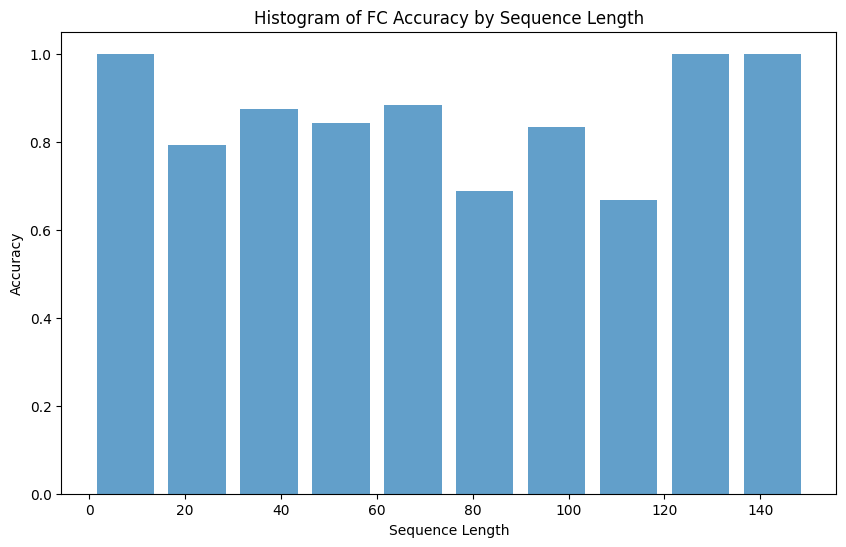

In [265]:

# Plot histogram
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, accuracy_scores, align='center', alpha=0.7, width=(bin_edges[1] - bin_edges[0]) * 0.8)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Histogram of FC Accuracy by Sequence Length')
plt.show()

In [266]:
accuracy_scores = []

# Train and evaluate the model on each bin
for bin_idx in range(1,len(bin_edges)):
    bin_mask = df['Bin'] == bin_idx
    bin_dataset = MolecularDataset(flattened_onehot[bin_mask], labels_org[bin_mask])

    # Split the bin dataset into training, validation, and testing sets
    X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(bin_dataset.sequences, bin_dataset.labels, test_size=0.3, random_state=42)
    batch_size = 64
    train_loader_bin = DataLoader(MolecularDataset(X_train_bin, y_train_bin), batch_size=batch_size, shuffle=True)
    valid_loader_bin = DataLoader(MolecularDataset(X_temp_bin, y_temp_bin), batch_size=batch_size, shuffle=False)
#     test_loader_bin = DataLoader(MolecularDataset(X_test_bin, y_test_bin), batch_size=batch_size, shuffle=False)

    # Instantiate the model, loss function, and optimizer
    input_size_bin = flattened_onehot.size(1)
    hidden_size_bin = 64

    fc_model_bin = LSTMWithFCModel(input_size, hidden_size, lstm_layers , fc_hidden_size)
    fc_model_bin.apply(reset_weights)
    
    criterion_fc_bin = nn.BCEWithLogitsLoss()
    optimizer_fc_bin = optim.Adam(fc_model_bin.parameters(), lr=0.001)

    # Training loop for the FC model on the current bin
    num_epochs_bin = 10
    best_accuracy_bin = 0.0

    for epoch in range(num_epochs_bin):
        fc_model_bin.train()
        for inputs, labels in train_loader_bin:
            optimizer_fc_bin.zero_grad()
            outputs_fc_bin = fc_model_bin(inputs)
            loss_fc_bin = criterion_fc_bin(outputs_fc_bin.squeeze(), labels)
            loss_fc_bin.backward()
            optimizer_fc_bin.step()

    # Validation
    fc_model_bin.eval()
    with torch.no_grad():
        correct_fc_bin = 0
        total_fc_bin = 0
        for inputs, labels in valid_loader_bin:
            outputs_fc_bin = fc_model_bin(inputs)
            predicted_fc_bin = (outputs_fc_bin.squeeze() > 0.5).float()
            total_fc_bin += labels.size(0)
            correct_fc_bin += (predicted_fc_bin == labels).sum().item()

        accuracy_fc_bin = correct_fc_bin / total_fc_bin
        print(f'Bin {bin_idx}/{len(bin_edges) - 1}, Validation Accuracy LSTM: {accuracy_fc_bin * 100:.2f}%')
        
        accuracy_scores.append(accuracy_fc_bin)

Bin 1/10, Validation Accuracy LSTM: 0.00%
Bin 2/10, Validation Accuracy LSTM: 76.24%
Bin 3/10, Validation Accuracy LSTM: 85.59%
Bin 4/10, Validation Accuracy LSTM: 81.40%
Bin 5/10, Validation Accuracy LSTM: 76.81%
Bin 6/10, Validation Accuracy LSTM: 43.75%
Bin 7/10, Validation Accuracy LSTM: 83.33%
Bin 8/10, Validation Accuracy LSTM: 66.67%
Bin 9/10, Validation Accuracy LSTM: 100.00%
Bin 10/10, Validation Accuracy LSTM: 0.00%


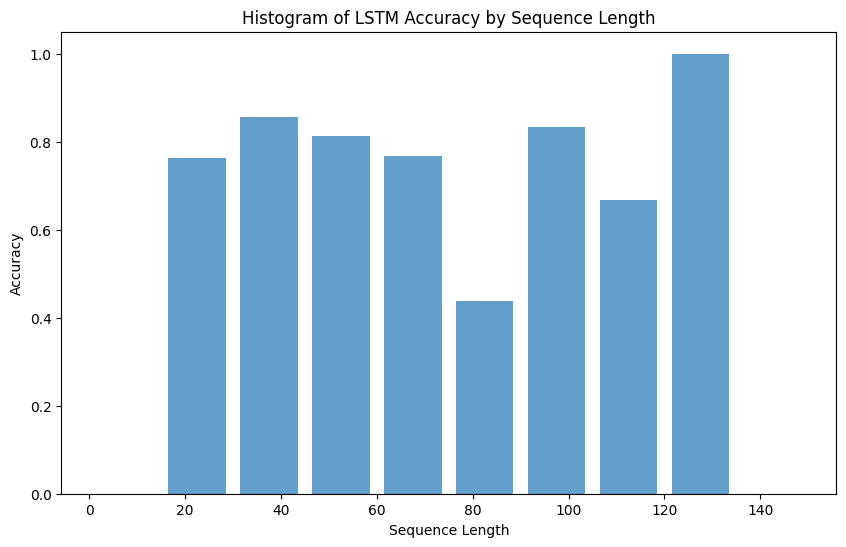

In [267]:

# Plot histogram
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, accuracy_scores, align='center', alpha=0.7, width=(bin_edges[1] - bin_edges[0]) * 0.8)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Histogram of LSTM Accuracy by Sequence Length')
plt.show()

In [268]:
accuracy_scores = []

# Train and evaluate the model on each bin
for bin_idx in range(1,len(bin_edges)):
    bin_mask = df['Bin'] == bin_idx
    bin_dataset = MolecularDataset(flattened_onehot[bin_mask], labels_org[bin_mask])

    # Split the bin dataset into training, validation, and testing sets
    X_train_bin, X_temp_bin, y_train_bin, y_temp_bin = train_test_split(bin_dataset.sequences, bin_dataset.labels, test_size=0.3, random_state=42)
    batch_size = 64
    train_loader_bin = DataLoader(MolecularDataset(X_train_bin, y_train_bin), batch_size=batch_size, shuffle=True)
    valid_loader_bin = DataLoader(MolecularDataset(X_temp_bin, y_temp_bin), batch_size=batch_size, shuffle=False)
#     test_loader_bin = DataLoader(MolecularDataset(X_test_bin, y_test_bin), batch_size=batch_size, shuffle=False)

    # Instantiate the model, loss function, and optimizer
    input_size_bin = flattened_onehot.size(1)
    hidden_size_bin = 64

    fc_model_bin = BiLSTMWithFCModel(input_size, hidden_size, lstm_layers , fc_hidden_size)
    fc_model_bin.apply(reset_weights)
    
    criterion_fc_bin = nn.BCEWithLogitsLoss()
    optimizer_fc_bin = optim.Adam(fc_model_bin.parameters(), lr=0.001)

    # Training loop for the FC model on the current bin
    num_epochs_bin = 10
    best_accuracy_bin = 0.0

    for epoch in range(num_epochs_bin):
        fc_model_bin.train()
        for inputs, labels in train_loader_bin:
            optimizer_fc_bin.zero_grad()
            outputs_fc_bin = fc_model_bin(inputs)
            loss_fc_bin = criterion_fc_bin(outputs_fc_bin.squeeze(), labels)
            loss_fc_bin.backward()
            optimizer_fc_bin.step()

    # Validation
    fc_model_bin.eval()
    with torch.no_grad():
        correct_fc_bin = 0
        total_fc_bin = 0
        for inputs, labels in valid_loader_bin:
            outputs_fc_bin = fc_model_bin(inputs)
            predicted_fc_bin = (outputs_fc_bin.squeeze() > 0.5).float()
            total_fc_bin += labels.size(0)
            correct_fc_bin += (predicted_fc_bin == labels).sum().item()

        accuracy_fc_bin = correct_fc_bin / total_fc_bin
        print(f'Bin {bin_idx}/{len(bin_edges) - 1}, Validation Accuracy BiLSTM: {accuracy_fc_bin * 100:.2f}%')
        
        accuracy_scores.append(accuracy_fc_bin)

Bin 1/10, Validation Accuracy BiLSTM: 86.36%
Bin 2/10, Validation Accuracy BiLSTM: 78.22%
Bin 3/10, Validation Accuracy BiLSTM: 85.59%
Bin 4/10, Validation Accuracy BiLSTM: 84.88%
Bin 5/10, Validation Accuracy BiLSTM: 79.71%
Bin 6/10, Validation Accuracy BiLSTM: 62.50%
Bin 7/10, Validation Accuracy BiLSTM: 83.33%
Bin 8/10, Validation Accuracy BiLSTM: 66.67%
Bin 9/10, Validation Accuracy BiLSTM: 100.00%
Bin 10/10, Validation Accuracy BiLSTM: 0.00%


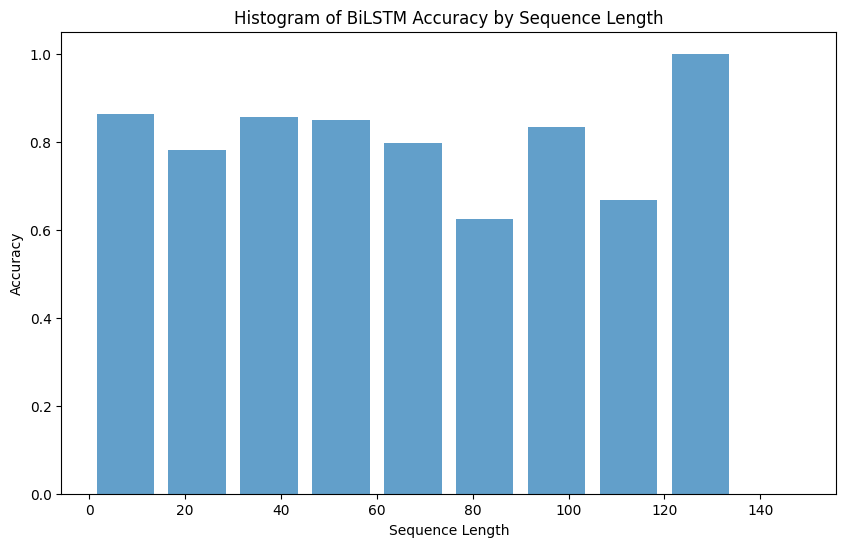

In [269]:

# Plot histogram
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, accuracy_scores, align='center', alpha=0.7, width=(bin_edges[1] - bin_edges[0]) * 0.8)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Histogram of BiLSTM Accuracy by Sequence Length')
plt.show()